In [1]:
#importing libraries
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
# from patchify import patchify
from PIL import Image
import tensorflow as tf
from osgeo import gdal
import tifffile as tiff
from tifffile import imsave
import rasterio as rio
import glob
import random


from tensorflow.keras.utils import normalize
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from keras.models import load_model
from keras import backend
from tensorflow.keras.layers import Add, Multiply
# import visualkeras
# import 

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# src = r"C:/Users/AbhishekRawat/Desktop/data_and_model/" #dataset source location
src = r"C:/Users/Megha Negi/Desktop/New folder/"
patch_size = 512 #patches size in pixels to be done for image and mask
cv2.IMREAD_LOAD_GDAL #cv2 natively fails to load sentinel image, that is why GDAL is used in backend

8

In [4]:
# Load the data and preprocess it


X_tr = np.load(src+"numpy_arrays/model_array/xtrain.npy")
Y_tr = np.load(src+"numpy_arrays/model_array/ytrain.npy")

# X_tr = np.load(src+"numpy_arrays/model_array/x_small.npy")
# Y_tr = np.load(src+"numpy_arrays/model_array/y_small.npy")

X_val = np.load(src+"numpy_arrays/model_array/xval.npy")
Y_val = np.load(src+"numpy_arrays/model_array/yval.npy")
X_ts = np.load(src+"numpy_arrays/model_array/xtest.npy") 
Y_ts = np.load(src+"numpy_arrays/model_array/ytest.npy")

print(X_tr.shape, X_val.shape, X_ts.shape ,"\n", Y_tr.shape, Y_val.shape, Y_ts.shape)

(776, 512, 512, 4) (259, 512, 512, 4) (260, 512, 512, 4) 
 (776, 512, 512, 1) (259, 512, 512, 1) (260, 512, 512, 1)


In [ ]:
# tf.keras.metrics.RootMeanSquaredError(
#     name="root_mean_squared_error", dtype=None
# )

0
1
2
3
4
5


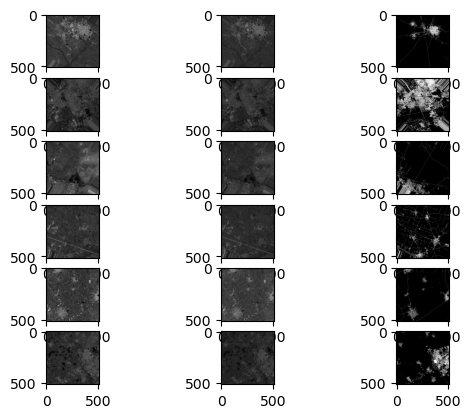

In [5]:
import numpy as np
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import AveragePooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D, Conv2DTranspose
from keras.layers import concatenate #Concatenate (capital C) not working 
# from keras.models import Concatenate
from keras.utils.vis_utils import plot_model
from keras.layers import Dropout
# from keras.optimizers import sgd
from tensorflow.keras.optimizers import SGD

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
import time
import skimage.transform

def rotateT(X,angle):
    #rotate image tensor, TF order, single channel
    X_rot = np.zeros_like(X)
    #repeat for every channel
    for ch in np.arange(X.shape[-1]):
        # print('channel',ch)
        #repeat for every image
        for i in np.arange(X.shape[0]):
            # print('image',i)
            X_rot[i,:,:,ch] = skimage.transform.rotate(X[i,:,:,ch],angle=angle,resize=False,preserve_range=True,mode='edge')
    return(X_rot)

def shiftT(X,dx,dy):
    #rotate image tensor, TF order, single channel
    X_shift = np.zeros_like(X)
    #repeat for every image
    tform = skimage.transform.SimilarityTransform(translation=(dx, dy))
    for i in np.arange(X.shape[0]):
        # print('image',i)
        X_shift[i,:,:,:] = skimage.transform.warp(X[i,:,:,:],tform,mode='edge')
    return(X_shift)

#%%
def aug_generator(X_raw=None,Y_raw=None,
                  batch_size=4,
                  flip_axes=['x','y'],
                  rotation_angles=[45,90,135,180,225,270,315]):
                #   noise_gaussian_mean=0,
                #   noise_gaussian_var=1e-2):
                #   noise_snp_amount=0.05):
    
    batch_size=batch_size#recommended batch size    
    Ndatapoints = len(X_raw)
    # Naugmentations=4 #original + flip, rotation, noise_gaussian, noise_snp
    
    while(True):
        # print('start!')
        ix_randomized = np.random.choice(Ndatapoints,size=Ndatapoints,replace=False)
        ix_batches = np.array_split(ix_randomized,int(Ndatapoints/batch_size))
        for b in range(len(ix_batches)):
            # print('step',b,'of',len(ix_batches))
            ix_batch = ix_batches[b]
            current_batch_size=len(ix_batch)
            # print('size of current batch',current_batch_size)
            # print(ix_batch)
            X_batch = X_raw[ix_batch,:,:,:].copy()#.copy() to leave original unchanged
            Y_batch = Y_raw[ix_batch,:,:,:].copy()#.copy() to leave original unchanged
            
            #now do augmentation on images and masks
            #iterate over each image in the batch
            for img in range(current_batch_size):
                # print('current_image',img,': ',ix_batch[img])
                do_aug=np.random.choice([True, False],size=1)[0]#50-50 chance
                if do_aug == True:
                    # print('flipping',img)
                    flip_axis_selected = np.random.choice(flip_axes,1,replace=False)[0]
                    if flip_axis_selected == 'x':
                        flip_axis_selected = 1
                    else: # 'y'
                        flip_axis_selected = 0
                    #flip an axis
                    X_batch[img,:,:,:] = np.flip(X_batch[img,:,:,:],axis=flip_axis_selected)
                    Y_batch[img,:,:,:] = np.flip(Y_batch[img,:,:,:],axis=flip_axis_selected)
                    # print('Flip on axis',flip_axis_selected)
                
                do_aug=np.random.choice([True, False],size=1)[0]#50-50 chance
                if do_aug == True:
                    # print('rotating',img)
                    rotation_angle_selected = np.random.uniform(low=rotation_angles[0],high=rotation_angles[1],size=1)[0]
                    #rotate the image
                    X_batch[img,:,:,:] = rotateT(np.expand_dims(X_batch[img,:,:,:],axis=0),angle=rotation_angle_selected)
                    Y_batch[img,:,:,:] = rotateT(np.expand_dims(Y_batch[img,:,:,:],axis=0),angle=rotation_angle_selected)
                    # print('Rotate angle',rotation_angle_selected)
            yield(X_batch,Y_batch)
            # print('step end after',b,'of',len(ix_batches)) 

#%% initialize the generator
gen_train = aug_generator(X_tr,Y_tr,batch_size=5,flip_axes=['x','y'])


#plot the augmentations
X_batch, Y_batch = next(gen_train)
Nbatch=len(X_batch)

#%
fig, axes = plt.subplots(Nbatch,3)
for i in range(Nbatch):
    print(i)
    axes[i,0].imshow(X_batch[i,:,:,0],cmap='gray')
    axes[i,1].imshow(X_batch[i,:,:,1],cmap='gray')
    axes[i,2].imshow(Y_batch[i,:,:,0],cmap='gray')

In [ ]:
# def attention_block(input_tensor, gating_tensor, filters):
#     # Apply 1x1 convolution on input tensor
#     theta = Conv2D(filters, (1, 1), activation='relu')(input_tensor)
#     # Apply 1x1 convolution on gating tensor
#     phi = Conv2D(filters, (1, 1), activation='relu')(gating_tensor)
#     # Combine the two tensors by element-wise addition
#     combined = Add()([theta, phi])
#     # Apply activation function (e.g., sigmoid) to obtain attention coefficients
#     attention = Activation('sigmoid')(combined)
#     # Multiply attention coefficients with input tensor
#     attended = Multiply()([input_tensor, attention])
#     return attended

In [6]:
#%% set-up the UNET model

#model parameters
bnorm_axis = -1
#filter sizes of the original model
nfilters = np.array([64, 128, 256, 512, 1024])
# drop_rate=0.5
#drop_train=True
# drop_train=False
#downsize the UNET for this example.
#the smaller network is faster to train
#and produces excellent results on the dataset at hand
nfilters = (nfilters/8).astype('int')

#input
input_tensor = Input(shape=X_tr.shape[1:], name='input_tensor')

####################################
# encoder (contracting path)
####################################
#encoder block 0
e0 = Conv2D(filters=nfilters[0], kernel_size=(3,3), padding='same')(input_tensor)
e0 = BatchNormalization(axis=bnorm_axis)(e0)
e0 = Activation('relu')(e0)
e0 = Conv2D(filters=nfilters[0], kernel_size=(3,3), padding='same')(e0)
e0 = BatchNormalization(axis=bnorm_axis)(e0)
e0 = Activation('relu')(e0)

#encoder block 1
e1 = MaxPooling2D((2, 2))(e0)
e1 = Conv2D(filters=nfilters[1], kernel_size=(3,3), padding='same')(e1)
e1 = BatchNormalization(axis=bnorm_axis)(e1)
e1 = Activation('relu')(e1)
e1 = Conv2D(filters=nfilters[1], kernel_size=(3,3), padding='same')(e1)
e1 = BatchNormalization(axis=bnorm_axis)(e1)
e1 = Activation('relu')(e1)

#encoder block 2
# e2 = Dropout(drop_rate)(e1, training = drop_train)
e2 = MaxPooling2D((2, 2))(e1)
e2 = Conv2D(filters=nfilters[2], kernel_size=(3,3), padding='same')(e2)
e2 = BatchNormalization(axis=bnorm_axis)(e2)
e2 = Activation('relu')(e2)
e2 = Conv2D(filters=nfilters[2], kernel_size=(3,3), padding='same')(e2)
e2 = BatchNormalization(axis=bnorm_axis)(e2)
e2 = Activation('relu')(e2)

#encoder block 3
# e3 = Dropout(drop_rate)(e2, training = drop_train)
e3 = MaxPooling2D((2, 2))(e2)
e3 = Conv2D(filters=nfilters[3], kernel_size=(3,3), padding='same')(e3)
e3 = BatchNormalization(axis=bnorm_axis)(e3)
e3 = Activation('relu')(e3)
e3 = Conv2D(filters=nfilters[3], kernel_size=(3,3), padding='same')(e3)
e3 = BatchNormalization(axis=bnorm_axis)(e3)
e3 = Activation('relu')(e3)

#encoder block 4
# e4 = Dropout(drop_rate)(e3, training = drop_train)
e4 = MaxPooling2D((2, 2))(e3)
e4 = Conv2D(filters=nfilters[4], kernel_size=(3,3), padding='same')(e4)
e4 = BatchNormalization(axis=bnorm_axis)(e4)
e4 = Activation('relu')(e4)
e4 = Conv2D(filters=nfilters[4], kernel_size=(3,3), padding='same')(e4)
e4 = BatchNormalization(axis=bnorm_axis)(e4)
e4 = Activation('relu')(e4)
# e4 = MaxPooling2D((2, 2))(e4)

# # Attention module
# att = attention_block(e4,e3, filters=nfilters[3])


####################################
# decoder (expansive path)
####################################

#decoder block 3
# d3 = Dropout(drop_rate)(e4, training = drop_train)
d3=UpSampling2D((2, 2),)(e4)
d3=concatenate([e3,d3], axis=-1)#skip connection
d3=Conv2DTranspose(nfilters[3], (3, 3), padding='same')(d3)
d3=BatchNormalization(axis=bnorm_axis)(d3)
d3=Activation('relu')(d3)
d3=Conv2DTranspose(nfilters[3], (3, 3), padding='same')(d3)
d3=BatchNormalization(axis=bnorm_axis)(d3)
d3=Activation('relu')(d3)
# d3_attended = attention_block(d3, e3, filters=nfilters[3])

#decoder block 2
# d2 = Dropout(drop_rate)(d3, training = drop_train)
d2=UpSampling2D((2, 2),)(d3)
d2=concatenate([e2,d2], axis=-1)#skip connection
d2=Conv2DTranspose(nfilters[2], (3, 3), padding='same')(d2)
d2=BatchNormalization(axis=bnorm_axis)(d2)
d2=Activation('relu')(d2)
d2=Conv2DTranspose(nfilters[2], (3, 3), padding='same')(d2)
d2=BatchNormalization(axis=bnorm_axis)(d2)
d2=Activation('relu')(d2)
# d2_attended = attention_block(d2, e2, filters=nfilters[2])

#decoder block 1
d1=UpSampling2D((2, 2),)(d2)
d1=concatenate([e1,d1], axis=-1)#skip connection
d1=Conv2DTranspose(nfilters[1], (3, 3), padding='same')(d1)
d1=BatchNormalization(axis=bnorm_axis)(d1)
d1=Activation('relu')(d1)
d1=Conv2DTranspose(nfilters[1], (3, 3), padding='same')(d1)
d1=BatchNormalization(axis=bnorm_axis)(d1)
d1=Activation('relu')(d1)
# d1_attended = attention_block(d1, e1, filters=nfilters[1])

#decoder block 0
d0=UpSampling2D((2, 2),)(d1)
d0=concatenate([e0,d0], axis=-1)#skip connection
d0=Conv2DTranspose(nfilters[0], (3, 3), padding='same')(d0)
d0=BatchNormalization(axis=bnorm_axis)(d0)
d0=Activation('relu')(d0)
d0=Conv2DTranspose(nfilters[0], (3, 3), padding='same')(d0)
d0=BatchNormalization(axis=bnorm_axis)(d0)
d0=Activation('relu')(d0)
# d0_attended = attention_block(d0, e0, filters=nfilters[0])

#output
out_class = Dense(1)(d0)
out_class = Conv2D(1, (1, 1), padding='same')(d0)
out_class = Activation('linear',name='output')(out_class)

#create and compile the model
model=Model(inputs=input_tensor,outputs=out_class)
model.compile(loss={'output':'huber_loss'},
              metrics={'output':'mean_squared_error'},
              optimizer='SGD')

#%%
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_tensor (InputLayer)      [(None, 512, 512, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 8)  296         ['input_tensor[0][0]']           
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

                                                                                                  
 activation_8 (Activation)      (None, 32, 32, 128)  0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_9 (Conv2D)              (None, 32, 32, 128)  147584      ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 32, 32, 128)  512        ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_9 (Activation)      (None, 32, 32, 128)  0           ['batch_normalization_9[0][0]']  
                                                                                                  
 up_sampli

                                )                                 'up_sampling2d_3[0][0]']        
                                                                                                  
 conv2d_transpose_6 (Conv2DTran  (None, 512, 512, 8)  1736       ['concatenate_3[0][0]']          
 spose)                                                                                           
                                                                                                  
 batch_normalization_16 (BatchN  (None, 512, 512, 8)  32         ['conv2d_transpose_6[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 activation_16 (Activation)     (None, 512, 512, 8)  0           ['batch_normalization_16[0][0]'] 
                                                                                                  
 conv2d_tr

In [ ]:
# #Visualize the model

# from keras import layers
# from collections import defaultdict
# colorMap = defaultdict(dict) #customize the colours
# colorMap[layers.InputLayer]['fill'] = 'black'
# colorMap[layers.Conv2D]['fill'] = 'orange'
# colorMap[layers.MaxPooling2D]['fill'] = 'red'
# colorMap[layers.Dropout]['fill'] = 'pink'
# colorMap[layers.Activation]['fill'] = 'purple'
# colorMap[layers.UpSampling2D]['fill'] = 'teal'
# colorMap[layers.BatchNormalization]['fill'] = 'cyan'
# colorMap[layers.Concatenate]['fill'] = 'yellow'
# colorMap[layers.Conv2DTranspose]['fill'] = 'green'
# # visualkeras.layered_view(model, legend=True) # without custom font
# from PIL import ImageFont
# font = ImageFont.truetype("arial.ttf", 60)
# # visualkeras.layered_view(model, legend=True, font=font) # selected font
# visualkeras.layered_view(model, legend=True, font=font,spacing=30,color_map=colorMap)

In [7]:
#%% train the model
filepath = src+'model/test/t2/unet_regg'

#save the model when val_loss improves during training
checkpoint = ModelCheckpoint(filepath+'.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
#save training progress in a .csv
csvlog = CSVLogger(filepath+'_train_log.csv',append=True)
#stop training if no improvement has been seen on val_loss for a while
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20)
batch_size=1

# initialize the generator
gen_train = aug_generator(X_tr,Y_tr,batch_size=batch_size,flip_axes=[1,2])
#split the array and see how many splits there are to determine #steps
steps_per_epoch_tr = len(np.array_split(np.zeros(len(X_tr)),int(len(X_tr)/batch_size)))

#actually do the training
history = model.fit_generator(generator=gen_train,
                              steps_per_epoch=steps_per_epoch_tr,#the generator internally goes over the entire dataset in one iteration
                              validation_data=(X_val,Y_val),
                              epochs=100,
                              verbose=1,
                              initial_epoch=0,
                              callbacks=[checkpoint, csvlog, early_stopping])

Epoch 1/100


C:\Users\Megha Negi\AppData\Local\Temp\ipykernel_20116\489038320.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=gen_train,


776/776 [==============================] - ETA: 0s - loss: 5.2227 - mean_squared_error: 333.4092
Epoch 1: val_loss improved from inf to 5.32963, saving model to C:/Users/Megha Negi/Desktop/New folder/model/test/t2\unet_regg.hdf5


ImportError: `save_model()` using h5 format requires h5py. Could not import h5py.

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['mean_squared_error']
val_acc = history.history['val_mean_squared_error']
plt.plot(epochs, acc, 'y', label='Training mse')
plt.plot(epochs, val_acc, 'r', label='Validation mse')
plt.title('Training and validation mse')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# U-Net
def UNet(input_shape):
    inputs = Input(input_shape)
    # Encoding
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    #Decoding
    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    # The Sigmoid activation is used for having 0 and 1 as outputs.
    conv10 = Conv2D(1, (1, 1), activation='linear')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    return model

# Compile
input_shape = X_tr.shape[1:]
model_unet = UNet(input_shape)

model_unet.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-4),
                   loss= "mean_squared_error", 
                   metrics=[tf.keras.metrics.RootMeanSquaredError()],
                   #run_eagerly = True
                   )
tf.keras
model_unet.summary()

#%% train the model
filepath = src+'model/high_bu/unet_regg'

#save the model when val_loss improves during training
checkpoint = ModelCheckpoint(filepath+'.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
#save training progress in a .csv
csvlog = CSVLogger(filepath+'_train_log.csv',append=True)
#stop training if no improvement has been seen on val_loss for a while
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20)
batch_size=4

#split the array and see how many splits there are to determine #steps
steps_per_epoch_tr = len(np.array_split(np.zeros(len(X_tr)),int(len(X_tr)/batch_size)))
print(steps_per_epoch_tr)
#split the array and see how many splits there are to determine #steps
steps_per_epoch_val = len(np.array_split(np.zeros(len(X_val)),int(len(X_val)/batch_size)))
print(steps_per_epoch_val)


In [ ]:
# Training
model_unet.fit(X_tr, Y_tr, 
               epochs= 100,
               validation_data=(X_val, Y_val),
               batch_size = 9,
#                steps_per_epoch=steps_per_epoch_tr,#the generator internally goes over the entire dataset in one iteration
               initial_epoch = 0,
               verbose=1,
               validation_steps= 18
#                validation_batch_size=4,
#                callbacks = [checkpoint, csvlog, early_stopping]
              ) # validation_split=0.2